<a href="https://colab.research.google.com/github/tusker4/Sesac_Saltlux_Team5/blob/sunghee/13_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5_%ED%9A%8C%EA%B7%80_kaggle_%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글


- 경진대회 메달 조건

|--|0~99팀|100~249팀|250~999팀|1000팀 이상|
|--|--|--|--|--|
|금|상위 10%|상위 1위|상위 10위+0.2%|상위 10%+0.2%|
|은|상위 20%|상위 20%|상위 50위|상위 5%|
|동|상위 40%|상위 40%|상위 100위|상위 10%|

In [237]:
from IPython.display import Image

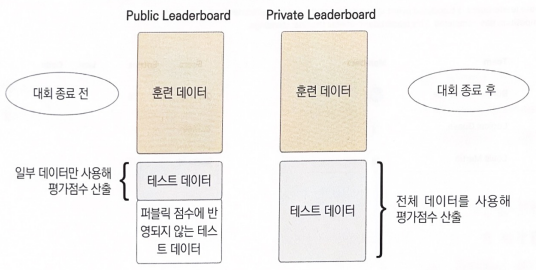

In [238]:
Image('/content/drive/MyDrive/머신러닝(솔트룩스)/reg/ml_캐글평가데이터차이.png')

In [239]:
# 퍼블릭 점수와 프라이빗 점수차이 발생(쉐이크업 현상)

# 개요

- 자전거 대여 수요 예측 경진대회
- 장소 : 워싱턴DC
  - 북반구(우리나라와 계절이 유사), 바다, 미국 수도
- 피처
  - 날짜, 계절, 근무일, 휴일, 날씨, 온도, 체감온도, 풍속,
- 유형 : 회귀
- 평가지표 : RMS**L**E (편차, 평균, 제곱, 로그)
  - 로그포함 -> 타겟값의 정규분포 체크
  - 필요시 **로그변환** 사용 확률이 높다.
- 배경
  - 2014.05 ~ 2015.05 (대회기간 : 1년)
  - 데이터 2011 ~ 2012, 한시간 간격
    - 훈련데이터 1일 ~ 19일
    - 테스트데이터 20일 ~ 말일
      - 일별데이터 사용하기 곤란하다 (말일이 애매)
  - 대여방식
    - 한 장소에서 픽업 => 이용 => 다른 장소에 반납
    

# 2~4.  데이터 준비 (수집, 준비, 분석)

- 머신러닝 워크플로우 step 2~4 통합


In [240]:
import pandas as pd
import numpy as np

In [241]:
train = pd.read_csv ('/content/drive/MyDrive/머신러닝(솔트룩스)/Q3/Q3/train.csv')
test = pd.read_csv ('/content/drive/MyDrive/머신러닝(솔트룩스)/Q3/Q3/test.csv')
submission = pd.read_csv ('/content/drive/MyDrive/머신러닝(솔트룩스)/Q3/Q3/sampleSubmission.csv')

train.shape , test.shape, submission.shape
# ((10886, 12), (6493, 9), (6493, 2)) : shape 가 조금 다르니 피처확인

((10886, 12), (6493, 9), (6493, 2))

# 새 섹션

In [242]:
# 피처확인
print(train.columns)
print(test.columns)
#  test 데이터에서 'casual', 'registered', 'count' 누락
print(submission.columns)
# submission 데이터에서는  'casual', 'registered' 누락

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')
Index(['datetime', 'count'], dtype='object')


- 피처데이터
  -  'casual', 'registered' 제거
  - 'count' 는 정답(수요량) 유지
  - 기준 : 'datetime'
    - 테스트 데이터의 datetime을 체크하여 수요예측을 해야할 년일월시분초를 체크할수 있다.

- 훈련용 피처 데이터 체크

|피처명|특징|--|--|--|
|--|--|--|--|--|
|datetime|주기성,1시간단위/년/월/일/시/분/초/요일||--|--|
|season|봄-여름-가을-겨울/ 1-2-3-4 : 순서형 or 단순 명목형||--|--|
|holiday|공휴일/0-1|--|--|--|
|workingday|일하는날/0-1/이진형||--|--|
|weather|날씨/1:맑음/2:약간흐림/3:약간의눈과비/4:폭풍,천둥번개|--|--|--|
|temp|실제온도, 연속형|--|--|--|
|atemp|체감온도, 연속형|--|--|--|
|humidity|상대습도, 연속형|--|--|--|
|windspeed|풍속, 연속형|--|--|--|
|<b>count</b>|종속변수/수요량/연속형|--|--|--|

In [243]:
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [244]:
train.describe()
'''
    season : 1~4
    holiday, workingday : 0 or 1
    weather : 1~4
    temp, atemp, humidity, casual. registered, count : 연속형데이터 (이상치 생각)
'''


'\n    season : 1~4\n    holiday, workingday : 0 or 1\n    weather : 1~4\n    temp, atemp, humidity, casual. registered, count : 연속형데이터 (이상치 생각) \n'

## 결측치 확인

In [245]:
train.info()
# 결측치없음으로 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [246]:
test.info()
# 결측치없음으로 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


## EDA
- 데이터별 경향/성향, 특이점 체크
- 필요시 파생변수 생성(시간)
- 시각화를 위해 범주형 값 -> 명목형 일반값으로 변형처리 고려, 혹은 레이블 처리(범례)
- 이를 기반으로 피처엔지니어링 진행


### datetime 피처

- 샘플 2011-01-01 :00 ~ 2012-12-19 데이터 중 하나
  - 2011-01-01 부터 1년간 데이터(단 월별 19일치)
- 년, 월, 일, 시, 분, 초, 요일 데이터 추출(전처리 필요)

In [247]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [248]:
# 날짜 데이터에서 성분별 추출(문자열처리 or 시간데이터로 처리)

'2012-12-19 21:00:00'.split()[0].split('-'), \
'2012-12-19 21:00:00'.split()[1].split(':')

(['2012', '12', '19'], ['21', '00', '00'])

In [249]:
# 파생피처, year, month, day, hour, minute, second
# year생성

In [250]:
year = '2012-12-19 21:00:00'.split()[0].split('-')[0]
month = '2012-12-19 21:00:00'.split()[0].split('-')[1]
day = '2012-12-19 21:00:00'.split()[0].split('-')[2]
year, month,

('2012', '12')

In [251]:
hour = '2012-12-19 21:00:00'.split()[1].split(':')[0]
minute = '2012-12-19 21:00:00'.split()[1].split(':')[1]
second = '2012-12-19 21:00:00'.split()[1].split(':')[2]
hour, minute, second

('21', '00', '00')

In [252]:
# year 생성 -> 모든 datetime 데이터에 접근해서 하나씩 전처리후 (년도추출) 모아서 세팅
def get_year(x):
  return x.split()[0].split('-')[0]
train['year'] = train['datetime'].apply(get_year)
train['month'] = train['datetime'].apply(lambda x:  x.split()[0].split('-')[1])
train['day'] = train['datetime'].apply(lambda x:  x.split()[0].split('-')[2])

train['hour']   = train['datetime'].apply(lambda x:  x.split()[1].split(':')[0])
train['minute']   = train['datetime'].apply(lambda x:  x.split()[1].split(':')[1])
train['second']   = train['datetime'].apply(lambda x:  x.split()[1].split(':')[2])

train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,01,01,00,00,00


In [253]:
# 요일
import calendar
from datetime import datetime

datetime.strptime( '2012-12-19', '%Y-%m-%d').weekday()  # 요일을 숫자로
calendar.day_name[datetime.strptime( '2012-12-19', '%Y-%m-%d').weekday() ]

'Wednesday'

In [254]:
# 수치값으로 넣지 않고, EDA상 편하게 해석 가능하도록 요일명으로 넣겠다
train['weekday'] = train['datetime'].apply(lambda x: calendar.day_name[datetime.strptime( x.split()[0], '%Y-%m-%d').weekday() ] )
train.iloc[ :2, -7:]

,year,month,day,hour,minute,second,weekday
0,2011,01,01,00,00,00,Saturday
1,2011,01,01,01,00,00,Saturday


### season 데이터

In [255]:
# 수치형 데이터 => 명목형 : 계절명 교체 => map()
train['season'].unique()

array([1, 2, 3, 4])

In [256]:
train['season'] = train['season'].map({
    1:'spring', 2:'summer', 3: 'autumn', 4:'winter'
})
train['season'].unique()


array(['spring', 'summer', 'autumn', 'winter'], dtype=object)

In [257]:
# 날씨
train['weather'] = train['weather'].map({
    1:'good', 2:'week_blur', 3: 'week_snow_rain', 4:'strong_rain_th'
})
train['weather'].unique()

array(['good', 'week_blur', 'week_snow_rain', 'strong_rain_th'],
      dtype=object)

### 타겟데이터
- 분류에서는 층화, 비율등을 체크
- 회귀에서는 분포 체크
  - 평가지표에서 Log 가 체크


In [258]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


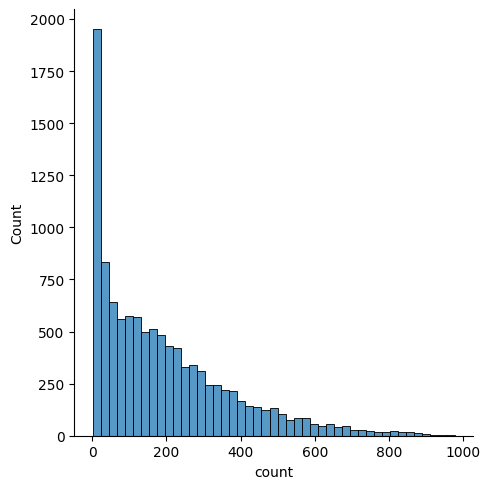

In [259]:
sns.displot(train['count']);

- 해석
  - x축 : count, y축: 카운트(빈도)
  - 왼쪽에 쏠려있다. -> 편향되었다. -> 0에 몰려있다
    - 대부분 자전거를 빌리지 않는 시간대 많았다.
  - 좋은 모델(예측을 잘하는 모델)을 위해서는 데이터를 **정규분포**를 따르게 만드는 것이 중요
    - 데이터 전처리(스케일링, 정규화등등)


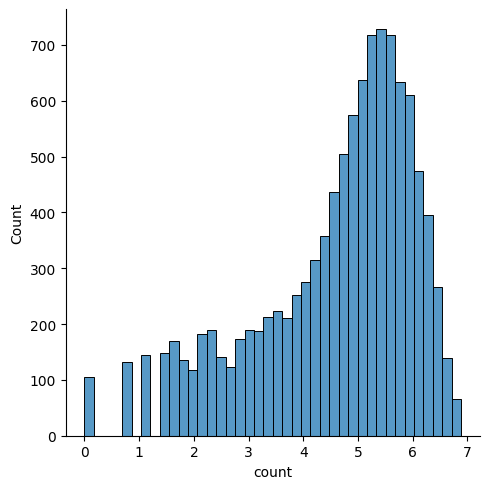

In [260]:
# 로그처리
sns.displot(np.log(train['count']));
# 정규분포에 가깝게 데이터 분포가 변경되었다.
# 이데이터로 학습 => 답도 로그처리된 결과가 나오기 때문에 => 복원(np.exp() ) => submission


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


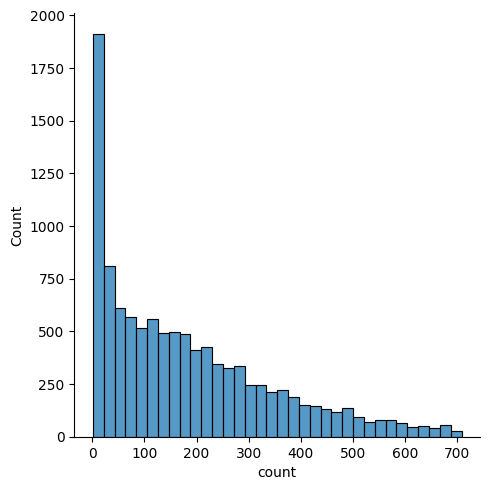

In [261]:
# 원본확인
sns.displot(np.log(np.exp((train['count']))));

- **로그변환 및 원본처리**를 해야하는 **평가함수**를 커스텀으로 구성할 필요가 있다.

### 년, 월, 일, 시, 분, 초,  대비 대여수량 /  y :평균 대여수량
 - 집계를 통해서 처리, 시각화에서 자동처리

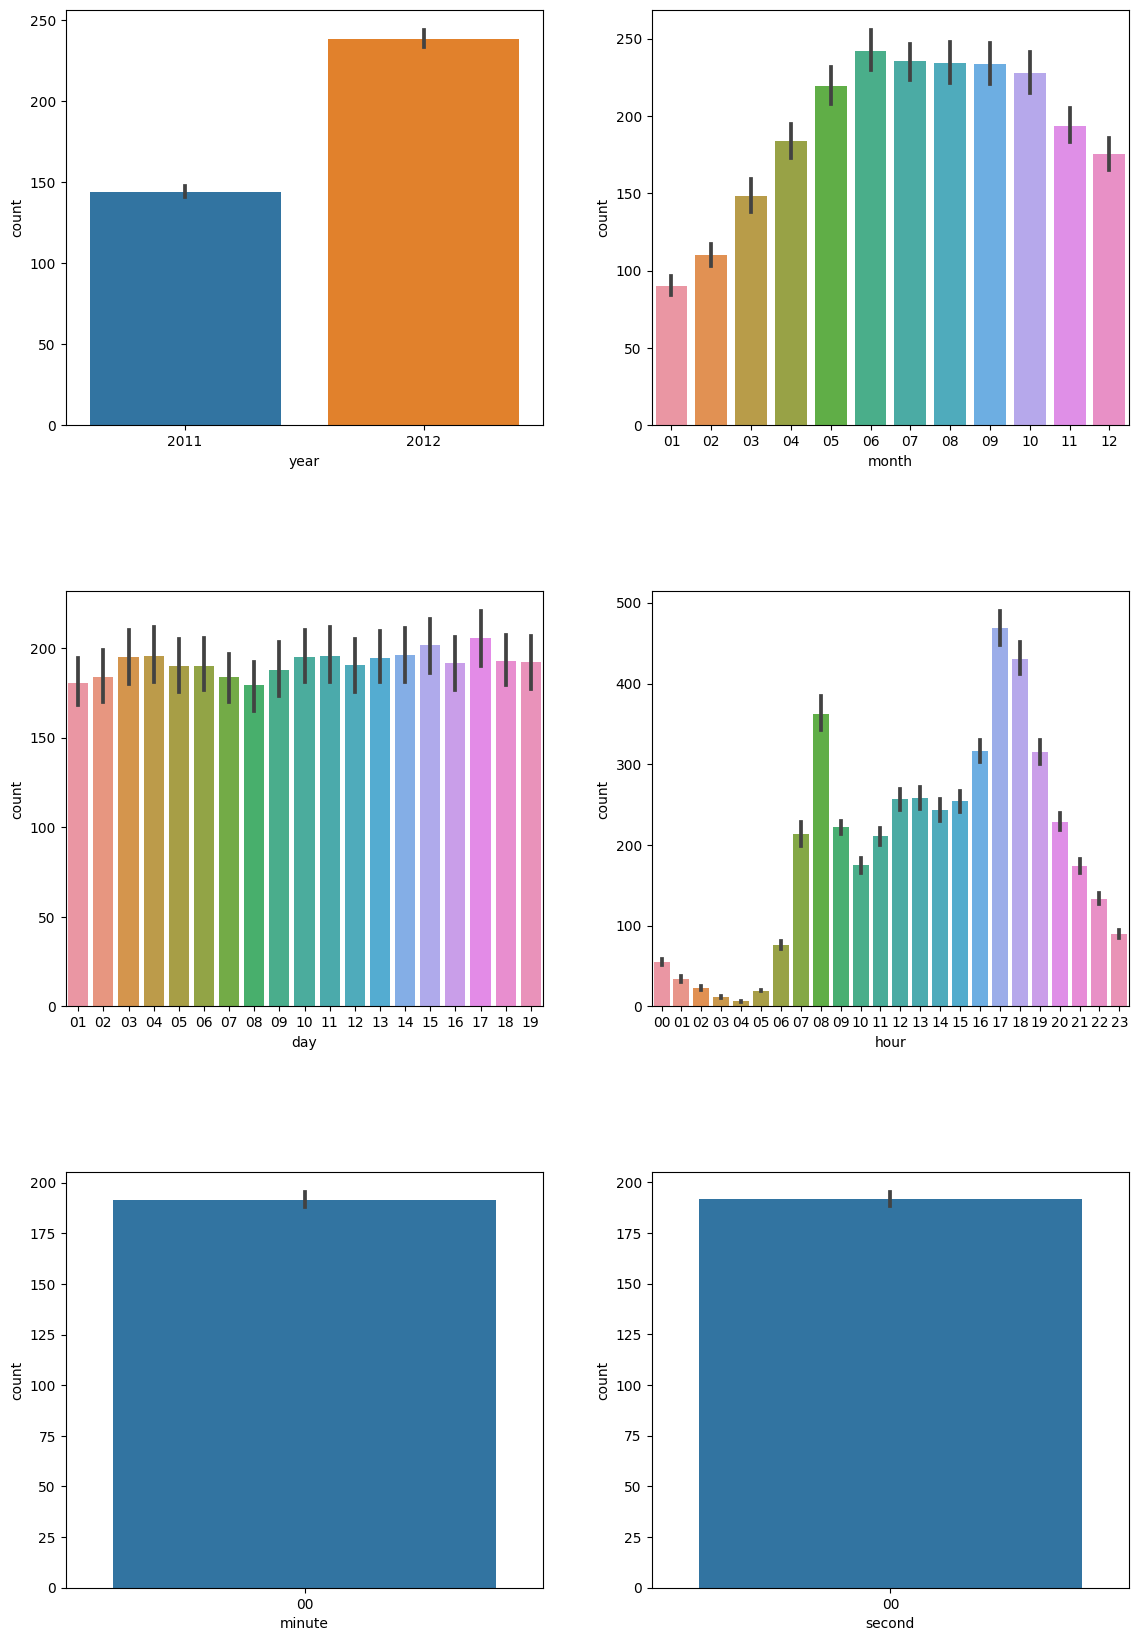

In [262]:
# 한줄에 차트 2개
nrows , ncols= 3 , 2
fig, axes = plt.subplots(nrows= nrows, ncols=ncols)
# 여백확보
plt.tight_layout()
fig.set_size_inches(6*ncols, 6*nrows)

# 바차트 + 오차범위 추가(이것을 기준으로 변별력이 있는지 체크)
sns.barplot(x= 'year', y='count', data=train, ax=axes[0,0] )
sns.barplot(x= 'month', y='count', data=train, ax=axes[0,1] )
sns.barplot(x= 'day', y='count', data=train, ax=axes[1,0] )
sns.barplot(x= 'hour', y='count', data=train, ax=axes[1,1] )
sns.barplot(x= 'minute', y='count', data=train, ax=axes[2,0] )
sns.barplot(x= 'second', y='count', data=train, ax=axes[2,1] )
'''
    - 해석
    - year : 2012년도 대여수가 더 많다. 오차범위도 바의 크기가 넘어선다 => 사용
    - minute, second : 오직0 만 존재: 의미X => 제거
    - month : 바간의 차이는 존재,  단 6~10월 사이는 바간 오차범위가 겹친다.
      - month를  3개씩 묶으면 seaoson 이 된다( 4계절 기준)ㅡ 제거 가능성이 큼
    - day   : 오차 범위가 모두 겹친다. 20일 이후는 학습불가 => 제거
    - hour : 일부 겹치는 `시간대가 존재하지만, 대체적으로 구분가능, 대부분 bar 값들이 오차범위 바깥에 존재
      - 특징: 피크타임(출퇴큰 : 8시전후, 17시 전후
      - 향후, 워킫데이, 홀리데이와 같이 어떤 특징을 표현할 것으로 얘상)
'''
plt.show()

### 워킹/ 홀리데이, 계절, 날씨
 - 2줄에 2칸으로 시각화
 - boxplot 사용


'\n    - 해석:\n    - 전체적으로 이상치가 많이 존재함. -> 성능에 영향을 미칠 요소\n    - season : 봄의 정의가 (1,2,3? 2,3,4? => 워싱톤 DC 날씨나 계절 표현을 확인 필요)\n      - 계절에 정의되는 월이 어떻게 되는지 추가 데이터 필요\n      - 계절간 변별은 되지만 차이가 크지는 않다. => 보류(사용 가능성이 큼)\n    - weather : 강한비 + 번개 기주에서 이상치가 발견(소수의 데이터)\n      - 강한비+번개 -> 소수(체크 필요 1개로 예상) -> 제거\n      - 날씨가 나빠질수록 날씨값이 커질수록 이용량은 낮아진다 (음의 상관관계가 보임)\n      => 사용\n    - workingday, holiday : 변별력이 잘 보이지 않음 (제거 가능성이 큼)\n'

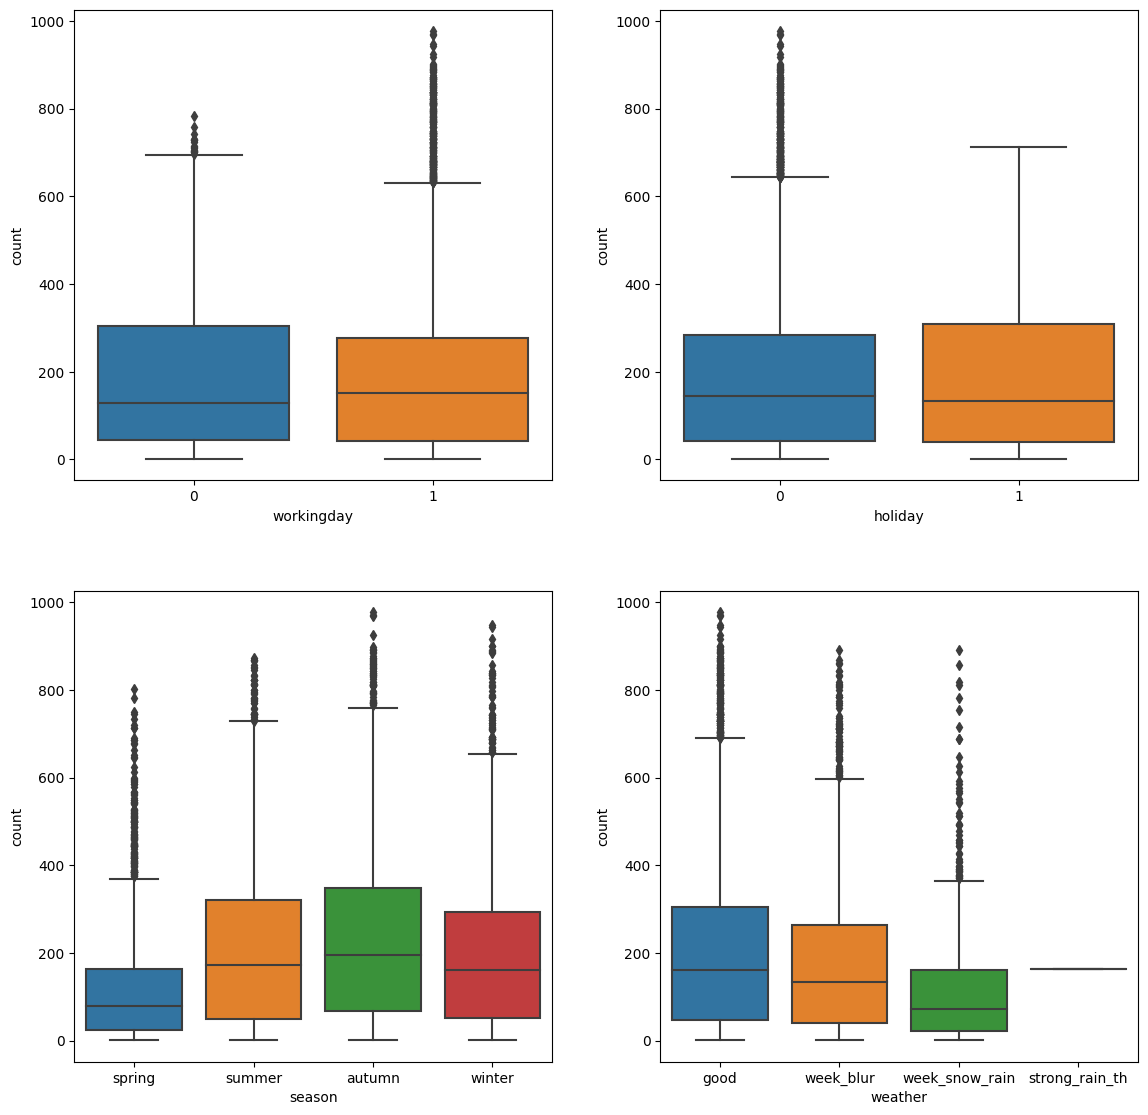

In [263]:
nrows , ncols= 2 , 2
fig, axes = plt.subplots(nrows= nrows, ncols=ncols)
plt.tight_layout()
fig.set_size_inches(6*ncols, 6*nrows)

sns.boxplot(x = 'workingday', y= 'count', data= train, ax= axes[0,0] )
sns.boxplot(x = 'holiday', y= 'count', data= train, ax= axes[0,1] )
sns.boxplot(x = 'season', y= 'count', data= train, ax= axes[1,0] )
sns.boxplot(x = 'weather', y= 'count', data= train, ax= axes[1,1] )

'''
    - 해석:
    - 전체적으로 이상치가 많이 존재함. -> 성능에 영향을 미칠 요소
    - season : 봄의 정의가 (1,2,3? 2,3,4? => 워싱톤 DC 날씨나 계절 표현을 확인 필요)
      - 계절에 정의되는 월이 어떻게 되는지 추가 데이터 필요
      - 계절간 변별은 되지만 차이가 크지는 않다. => 보류(사용 가능성이 큼)
    - weather : 강한비 + 번개 기주에서 이상치가 발견(소수의 데이터)
      - 강한비+번개 -> 소수(체크 필요 1개로 예상) -> 제거
      - 날씨가 나빠질수록 날씨값이 커질수록 이용량은 낮아진다 (음의 상관관계가 보임)
      => 사용
    - workingday, holiday : 변별력이 잘 보이지 않음 (제거 가능성이 큼)
'''



In [264]:
# 이상치가 많다 (검은색 점들이 이상치)

### 정답대비 범주형 데이터 EDA - 시간기준적용
- 포인트 플롯
  - 점 -> 선 연결 => 추세확인
  - 데이터의 평균과 신뢰구간을 점과선으로 연결
  - x:시간, y:카운트, hue:범주형데이터세팅
  

'\n    - workingday : 일하는날 (1) 출퇴근시 대여 수량이 급격히 증가(이 추세는)\n                  평일(월-금) vs 주말(토-일) 기준으로 봐도 동일\n                  일하는 날(1)의 추세는 계절성과 동일\n                  오차범위는 침범 X\n                  사용 가능성이 큼\n    - holiday : 1번값의 오차범위가 다른 선을 침범한다. = 학습에 도움X => 제거대상\n    - weekday : 월-금 vs 토-일 대비하면 workingday와 추세 동일\n                - 양의 상관관계가 강하게 있을듯 -> 사용은 하되, 강하면 제거(vif 때문)\n    - seasson : 봄과 다른 계절은 구분이 가능, 여름/가을/겨울은 거의 동일데이터(변별X)\n                - 봄대 다른계절은 가능(이진화)\n                - 이외에는 사용 불가(신뢰구간 침범) -> ???\n    - weather : 가장 안좋은 날씨 -> 제거, 나머지 값들은 학습시 가능\n\n'

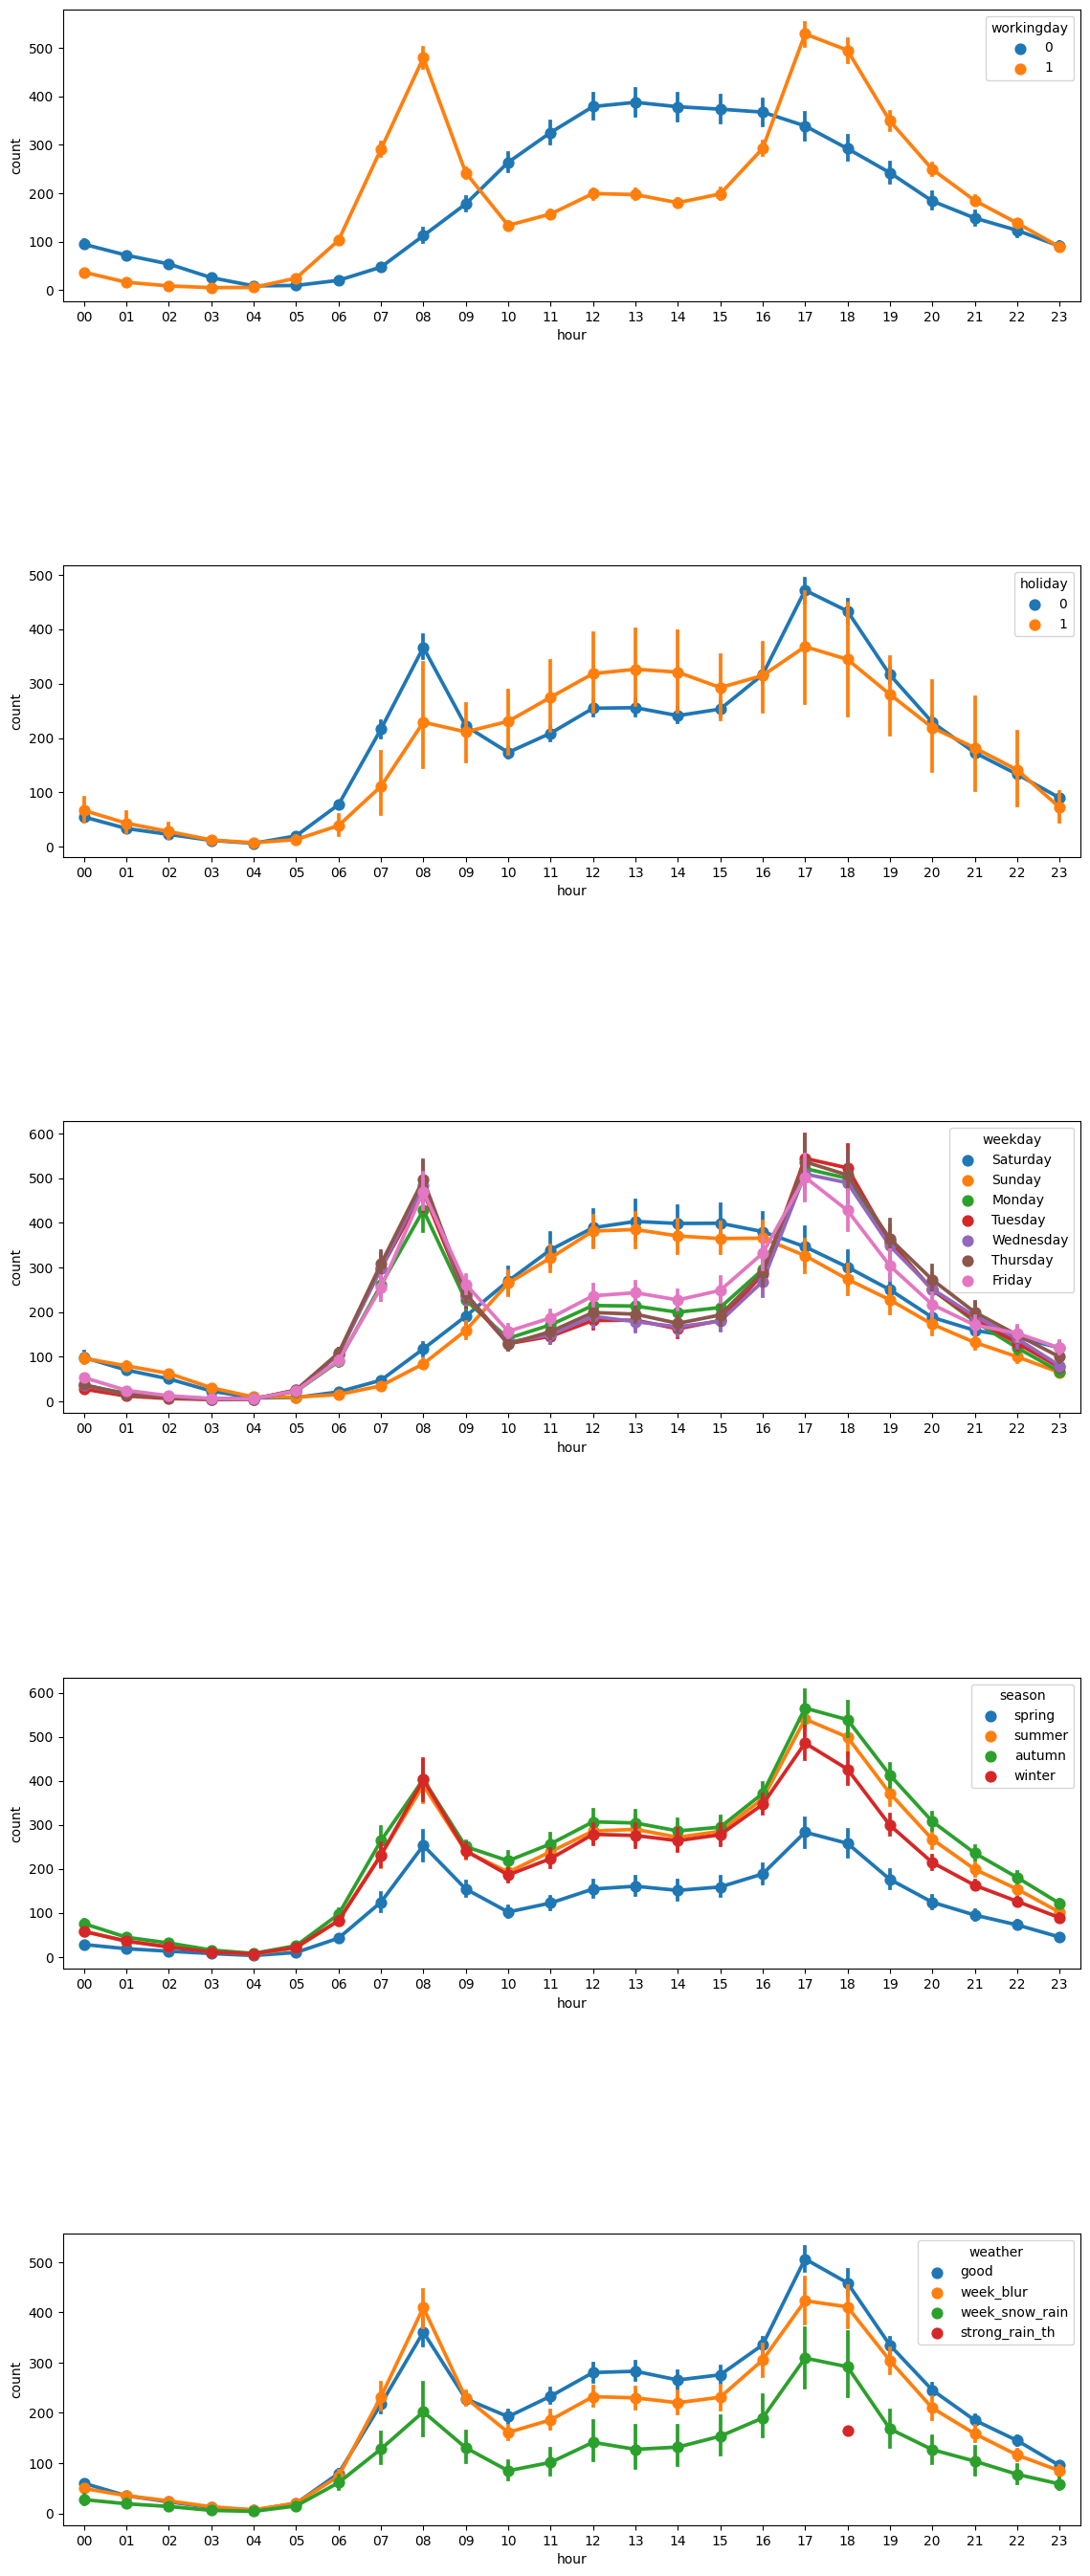

In [265]:
nrows , ncols= 5 , 1
fig, axes = plt.subplots(nrows= nrows, ncols=ncols)
plt.tight_layout()
fig.set_size_inches(12*ncols, 6*nrows)

sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4])


'''
    - workingday : 일하는날 (1) 출퇴근시 대여 수량이 급격히 증가(이 추세는)
                  평일(월-금) vs 주말(토-일) 기준으로 봐도 동일
                  일하는 날(1)의 추세는 계절성과 동일
                  오차범위는 침범 X
                  사용 가능성이 큼
    - holiday : 1번값의 오차범위가 다른 선을 침범한다. = 학습에 도움X => 제거대상
    - weekday : 월-금 vs 토-일 대비하면 workingday와 추세 동일
                - 양의 상관관계가 강하게 있을듯 -> 사용은 하되, 강하면 제거(vif 때문)
    - seasson : 봄과 다른 계절은 구분이 가능, 여름/가을/겨울은 거의 동일데이터(변별X)
                - 봄대 다른계절은 가능(이진화)
                - 이외에는 사용 불가(신뢰구간 침범) -> ???
    - weather : 가장 안좋은 날씨 -> 제거, 나머지 값들은 학습시 가능

'''


### 연속형 데이터 시각화
- 산점도(산포도) + 회귀선
  - regplot
  - 상관관계 체크가능
  - 피처 : 온도, 체감온도, 습도, 풍속

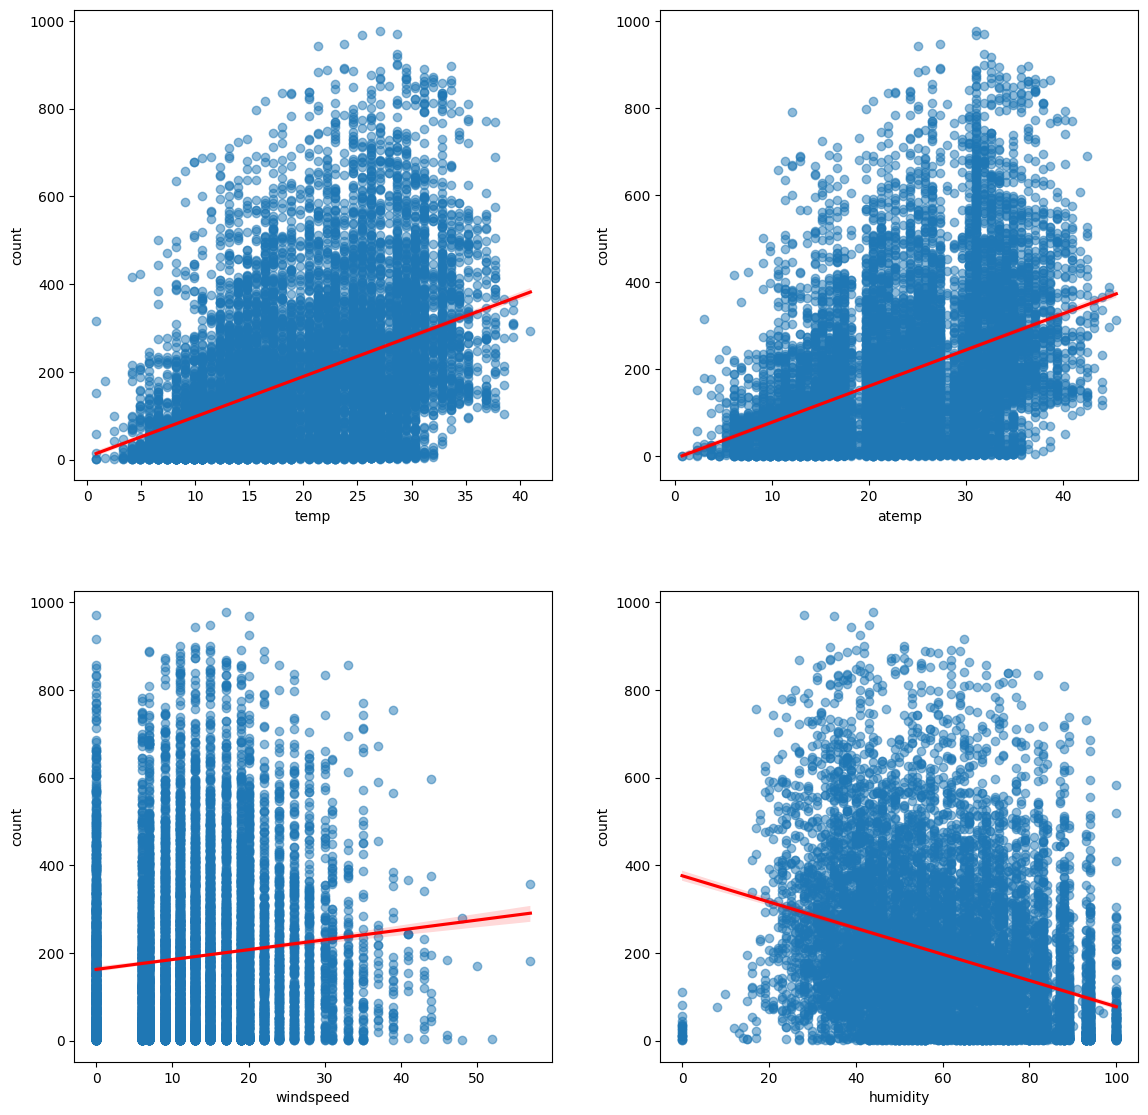

In [266]:
nrows , ncols= 2 , 2
fig, axes = plt.subplots(nrows= nrows, ncols=ncols)
plt.tight_layout()
fig.set_size_inches(6*ncols, 6*nrows)

# 회귀선 색상 변경, 포인트 투명도 조정 -> 밀집형태를 조정
sns.regplot(x='temp', y='count', data=train, ax=axes[0, 0], line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5});
sns.regplot(x='atemp', y='count', data=train, ax=axes[0, 1], line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5});
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1, 0], line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5});
sns.regplot(x='humidity', y='count', data=train, ax=axes[1, 1], line_kws={'color': 'red'},
            scatter_kws={'alpha': 0.5});
plt.show()

In [267]:
'''
    - 온도, 체감온도는 대여량과 양의 상관관계(비례적), 두개의 피처가 비슷(둘 사이 상관관계 체크 필요)
      - 0.9 이상이면 제거 대상, 다중공선성(VIF)을 낮추기 위해서 -> 모델 신뢰성 문제
    - 풍속 : 바람이 거셀수록 대여량이 늘어난다.(낮게)
      - 풍속 = 0 인 경우가 제법 많이 존재 => 센서불량 혹은 측정 불량으로 예측가능
      - 데이터량을 체크 => 피처 제거 대상
    - 습도 : 반비례적 특성(음의 상관관계), 0 데이터가 일부보인다.
      - 사용 가능성 큼
'''

'\n    - 온도, 체감온도는 대여량과 양의 상관관계(비례적), 두개의 피처가 비슷(둘 사이 상관관계 체크 필요)\n      - 0.9 이상이면 제거 대상, 다중공선성(VIF)을 낮추기 위해서 -> 모델 신뢰성 문제\n    - 풍속 : 바람이 거셀수록 대여량이 늘어난다.(낮게)\n      - 풍속 = 0 인 경우가 제법 많이 존재 => 센서불량 혹은 측정 불량으로 예측가능\n      - 데이터량을 체크 => 피처 제거 대상 \n    - 습도 : 반비례적 특성(음의 상관관계), 0 데이터가 일부보인다.\n      - 사용 가능성 큼\n'

### 상관관계 분석 - EDA
- 히트맵


In [268]:
# 상관관계 필요한 피처들 체크
corr_values = train[['temp', 'atemp', 'windspeed', 'humidity', 'count']].corr()
corr_values


,temp,atemp,windspeed,humidity,count
temp,1.000000,0.984948,-0.017852,-0.064949,0.394454
atemp,0.984948,1.000000,-0.057473,-0.043536,0.389784
windspeed,-0.017852,-0.057473,1.000000,-0.318607,0.101369
humidity,-0.064949,-0.043536,-0.318607,1.000000,-0.317371
count,0.394454,0.389784,0.101369,-0.317371,1.000000


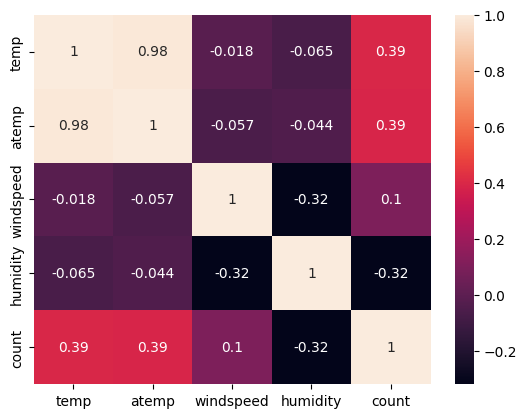

In [269]:
sns.heatmap(corr_values, annot=True);
# temp 와 atemp는 강한 양의 상관관계  ( > 0.9) 이기 때문에 => 둘중 하나만 핛습에 사용
# temp or atemp 는 각각 동일하게 count와 0.39의 상관관계를 가짐.
# 습도가 -0.32 정도 음의 상관관계를 가짐..

## 결과
- 피처제거
  - 파생변수
    - day, month, minute, seconde
  - windspeed
  - temp or atemp는 둘중하나만 사용(어떤것이 나올지는 결과론)
    - 전체 학습 데이터 기준 VIF 가 10이하이면 , 둘다 사용할 수 있다.(결과론, 절차상 제거가 합리적)
    
- 타겟데이터
  - np.log() 처리
  - 테스트데이터의 예츨값 = > np.exp() => submission 처리

- 이상치제거
  - weather 에서 가장 날씨가 좋지않은 상태값 제거

- 피처 스케일링
  - 베이스라인 단계에서 검토
  - 별도로 진행하지 않으면 파이캐럿에서 처리됨

# 모델 구축 - 베이스라인

In [270]:
train = pd.read_csv ('/content/drive/MyDrive/머신러닝(솔트룩스)/Q3/Q3/train.csv')
test = pd.read_csv ('/content/drive/MyDrive/머신러닝(솔트룩스)/Q3/Q3/test.csv')
submission = pd.read_csv ('/content/drive/MyDrive/머신러닝(솔트룩스)/Q3/Q3/sampleSubmission.csv')

train.shape , test.shape, submission.shape

((10886, 12), (6493, 9), (6493, 2))

## 피처엔지니어링

### 이상치 제거

In [271]:
train['weather'].unique()
# 피처 'weather'에서 값이 4인, 데이터를 제거 => 불리언인덱싱 처리
train = train[train['weather'] != 4 ]

train.shape
# (10886, 12) -> (10886, 11)

(10885, 12)

### 데이터 합치기
- 훈련용과 테스트용 병합하여, 피처엔지니어링 -> 최종 다시 분리

In [272]:
train.shape, test.shape

# 2개를 합치면 반드시 결측치가 발생(피처수가 달라서)
# 차후 다시분해할 때는 결측을 기준으로 분해


((10885, 12), (6493, 9))

In [273]:
# 데이터가 늘어나는 구조 이기때문에 = > axis=0 으로,  1차원으로, 수직으로, x쪽세계만
# 원데이터 인덱스 무시 : ignore_index

train_test_df = pd.concat([train, test], axis=0, ignore_index=True)
train_test_df.shape

(17378, 12)

In [274]:
# 테스트 데이터에서 누락된 피처 3개에 결측발생
train_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17378 non-null  object 
 1   season      17378 non-null  int64  
 2   holiday     17378 non-null  int64  
 3   workingday  17378 non-null  int64  
 4   weather     17378 non-null  int64  
 5   temp        17378 non-null  float64
 6   atemp       17378 non-null  float64
 7   humidity    17378 non-null  int64  
 8   windspeed   17378 non-null  float64
 9   casual      10885 non-null  float64
 10  registered  10885 non-null  float64
 11  count       10885 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


In [275]:
train_test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [276]:
# 중간값 확인 : => 결측의 시작위치 확인
train_test_df.iloc[train.shape[0]-1 :train.shape[0]+2  ] ## 붙은지점에서 결측치 확인


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10884,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4.0,84.0,88.0
10885,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN
10886,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN


### 파생 피처 생성
- 년, 시간, 요일

In [277]:
# 2011, 2012 => 두개 밖에 없으므로 0, 1로 대체(삼항연산자흉내) => 수치형대체
# 삼항연산자 : 참 일때 값 if 조건식 else 거짓일때 값
train_test_df['year'] = train_test_df['datetime'].apply(lambda x: 0 if '2011' == x.split()[0].split('-')[0] else 1)
# 00, 01, ... 23 => 0 ,1 ,2 => int() 처리 필요 => 수치형대체
train_test_df['hour'] = train_test_df['datetime'].apply(lambda x:  int(x.split()[1].split(':')[0]))
# weekday 수치형대체
train_test_df['weekday'] = train_test_df['datetime'].apply(lambda x: datetime.strptime( x.split()[0], '%Y-%m-%d').weekday() )


# (17678, 12) => (17378, 12+3)
train_test_df.shape

(17378, 15)

In [278]:
train_test_df.iloc[ : , -4:].head(5)



,count,year,hour,weekday
0,16.0,0,0,5
1,40.0,0,1,5
2,32.0,0,2,5
3,13.0,0,3,5
4,1.0,0,4,5


### 피처제거(혹은 선택)
- step 1
  - EDA를 통해서 제거 대상 선택
- step 2
  - 다중회귀 기반
    - **후진 제거법**
      - 뒤에있는 컬럼부터 제거하면서 학습 -> 예측 -> 평가반복
    - **전진 선택법**
      - 앞에 있는 컬럼부터 선택하면서, 학습 -> 예측 -> 평가 반복
    - **조합**에 문제
  - 피처의 **순서**
- step 3
  - **L1 규제**를 통해서 **회귀계수를 0**으로 만들어서 해당 피처 제거 (학습시 사용)

In [279]:
train_test_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'hour', 'weekday'],
      dtype='object')

In [280]:
drop_feats = ['datetime', 'windspeed', 'atemp', 'casual', 'registered' ]
train_test_df =  train_test_df.drop(drop_feats, axis =1)
train_test_df.info()
# 결측은 정답만 존재(테스트데이터), 모든 데이터는 수치화

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17378 entries, 0 to 17377
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17378 non-null  int64  
 1   holiday     17378 non-null  int64  
 2   workingday  17378 non-null  int64  
 3   weather     17378 non-null  int64  
 4   temp        17378 non-null  float64
 5   humidity    17378 non-null  int64  
 6   count       10885 non-null  float64
 7   year        17378 non-null  int64  
 8   hour        17378 non-null  int64  
 9   weekday     17378 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.3 MB


### 데이터 나누기

- 원본기준 훈련용, 테스트용 분리


In [281]:
# 테스트용, submission용
X_sub = train_test_df[pd.isnull(train_test_df['count'])]
X_sub.shape

(6493, 10)

In [282]:
# 훈련용
X = train_test_df[ ~pd.isnull(train_test_df['count'])]
X.shape

(10885, 10)

In [283]:
# 훈련용 데이터 준비
y = X['count']
X = X.drop(['count'], axis=1)
# 테스트용  데이터 준비 ?? X_sub??
X_sub = X_sub.drop(['count'], axis=1)

X.shape, y.shape, X_sub.shape

((10885, 9), (10885,), (6493, 9))

### 학습에 사용되는 훈련용, 테스트용 데이터 분리

In [284]:
# 학습에 사용되는 훈련용, 테스트용 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=0.25, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8163, 9), (2722, 9), (8163,), (2722,))

## 평가지표 커스텀 함수 행성

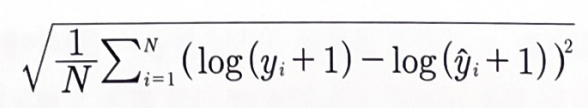

In [285]:
Image('/content/drive/MyDrive/머신러닝(솔트룩스)/reg/ml_rmsle_식.png')

Q. Y+1 하는이유?
  - 로그함수 특성상 x가 0에 가까워지면 최종값이 무한대로 갈수 있다(음/양의 무한대)
  - 이를 보정하기 위해서 둘다 1을 더한다 => 둘다 동일 비율로 조정했으므로 오차는 동일

In [286]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

def cus_rmsle( y_true, y_pred, transfer=True):
    '''
        - y_true:실제값, 정답
        - y_pred:예측값
        - transfer: True-로그처리된값->복원->np.exp()
    '''
    # 원래값 복원
    if transfer:
        y_true = np.exp( y_true )
        y_pred = np.exp( y_pred )

    # 로그변환
    # 로그변환후 결측치 발생 하면 0으로 보정 처리하는 함수 활용
    #log_y_true = np.nan_to_num( np.log(y_true+1) )
    #log_y_pred = np.nan_to_num( np.log(y_pred+1) )
    # 변환 전에 값이 너무 작으면 컴퓨터 계산산 오류 발생소지가 있음 => 보정 log1p()
    # log1p이 더 안정적임
    log_y_true = np.nan_to_num( np.log1p(y_true) )
    log_y_pred = np.nan_to_num( np.log1p(y_pred) )

    # RMSLE 처리
    return np.sqrt( np.mean( (log_y_true - log_y_pred)**2 ) )


## 모델생성-학습-예측-제출

In [287]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8163 entries, 10820 to 2732
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      8163 non-null   int64  
 1   holiday     8163 non-null   int64  
 2   workingday  8163 non-null   int64  
 3   weather     8163 non-null   int64  
 4   temp        8163 non-null   float64
 5   humidity    8163 non-null   int64  
 6   year        8163 non-null   int64  
 7   hour        8163 non-null   int64  
 8   weekday     8163 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 637.7 KB


In [288]:
from sklearn.linear_model import LinearRegression

# 알고리즘 생성
lr_model = LinearRegression()
# 정답데이터 변환
log_y    = np.log( y_train )
# 학습
lr_model.fit( X_train, log_y )

LinearRegression()

In [289]:
# 예측
y_pred = lr_model.predict(X_test)
# 평가
cus_rmsle(np.log(y_test), y_pred)

1.0113716342195682

In [290]:
# 예측
y_pred = lr_model.predict( X_test )
# 평가
cus_rmsle( np.log(y_test), y_pred )

1.0113716342195682

In [291]:
submission.tail(2)

,datetime,count
6491,2012-12-31 22:00:00,0
6492,2012-12-31 23:00:00,0


In [292]:
sub_y_pred = lr_model.predict( X_sub )
submission['count'] = np.exp( sub_y_pred )
submission.to_csv( 'submission_v1.csv', index=False )

### 대회 제출

- https://www.kaggle.com/c/bike-sharing-demand

# 최적화

## 규제 기본 모델 + cv + 그리드 서치 + 하이퍼파라미터

In [294]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer  # 커스텀 평가함수를 스코어링으로 사용시

In [295]:
lasso_model = Lasso()
param_grid = {
    'max_iter': [1000, 2000, 3000],
    'alpha' : 1/np.array([0.01, 0.1, 1, 2, 4, 8, 10, 100, 200, 300 ])

}
# 커스텀 함수를 스코어링으로 변환처리
my_rmsle_scorer = make_scorer(cus_rmsle, greater_is_better=False)
grid = GridSearchCV(lasso_model, param_grid, scoring=my_rmsle_scorer, cv=5)

# 교차검증
grid.fit(X_train, log_y)

# 베스트
print(grid.best_params_, grid.best_score_)

{'alpha': 0.01, 'max_iter': 1000} -1.0262369700250573


In [297]:
# 테스트데이터 예측값
y_pred = grid.best_estimator_.predict(X_test)
cus_rmsle(np.log(y_test), y_pred)

1.011443543053433

- 성능 개선 X,
  - 모델 교체 혹은 피처데이터 수정필요

## 앙상블 모델 + cv + 그리드 서치 + 하이퍼파라미터

In [300]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 120, 140],
    'random_state' : [0, 20, 42]

}

grid = GridSearchCV(rf_model, param_grid, scoring=my_rmsle_scorer, cv=5)

# 교차검증
grid.fit(X_train, log_y)

# 베스트
print(grid.best_params_, grid.best_score_)
# 테스트데이터 예측값
y_pred = grid.best_estimator_.predict(X_test)
cus_rmsle(np.log(y_test), y_pred)
# 0.40473 => 262등(제출시)


{'n_estimators': 140, 'random_state': 20} -0.3219083573166034


0.3156063147438075

In [301]:
sub_y_pred = grid.best_estimator_.predict(X_sub)
submission['count'] = np.exp(sub_y_pred)
submission.to_csv('submission_v2.csv', index=False)

## 풀데이터 사용 - 테스트 데이터도 모두 사용
- X 데이터, log_y를 풀데이터로 사용
  - AutoML에서
- 훈련 => submission 생성 => 제출
- 기존 데이터의 25를 더 추가학습 => 상승기대

## AutoML - 파이캐럿

In [302]:
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install -q pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.9 MB/s et

### 데이터 풀구성

- 캐글에서만 해볼 수 있는 치트키

In [304]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
X.shape, y.shape

((10885, 9), (10885,))

### 모듈 가져오기

In [305]:
from pycaret.regression import *


### setup

In [306]:
reg = setup(
    data = X, target = np.log(y), verbose = True, train_size = 0.9, data_split_shuffle=True,
    normalize=True, session_id = 100
)

,Description,Value
0,Session id,100
1,Target,count
2,Target type,Regression
3,Original data shape,"(10885, 10)"
4,Transformed data shape,"(10885, 10)"
5,Transformed train set shape,"(9796, 10)"
6,Transformed test set shape,"(1089, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


In [307]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


### top6 후보

In [308]:
top6_models = compare_models(fold=5, round=3, n_select=6, errors='ignore')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.205,0.100,0.315,0.955,0.110,0.069,3.112
lightgbm,Light Gradient Boosting Machine,0.220,0.110,0.332,0.950,0.112,0.072,1.592
xgboost,Extreme Gradient Boosting,0.222,0.115,0.339,0.948,0.116,0.074,0.246
rf,Random Forest Regressor,0.225,0.120,0.346,0.946,0.116,0.075,2.330
et,Extra Trees Regressor,0.230,0.127,0.357,0.943,0.123,0.078,1.438
gbr,Gradient Boosting Regressor,0.302,0.172,0.414,0.923,0.127,0.093,0.602
dt,Decision Tree Regressor,0.306,0.230,0.479,0.896,0.158,0.103,0.058
ada,AdaBoost Regressor,0.566,0.501,0.707,0.774,0.178,0.151,0.356
knn,K Neighbors Regressor,0.519,0.559,0.747,0.748,0.208,0.172,0.120
lr,Linear Regression,0.843,1.161,1.077,0.477,0.273,0.273,1.902


Processing:   0%|          | 0/90 [00:00<?, ?it/s]

### 탑 6 알고리즘 확인

In [310]:
top6_models

 LGBMRegressor(n_jobs=-1, random_state=100),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=100, ...),
 RandomForestRegressor(n_jobs=-1, random_state=100),
 ExtraTreesRegressor(n_jobs=-1, random_state=100),
 GradientBoostingRegressor(random_state=100)]

### 블랜딩

In [311]:
reg_blended = blend_models(estimator_list=top6_models, fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2076,0.0944,0.3073,0.9572,0.1041,0.0668
1,0.2007,0.0894,0.2990,0.9566,0.1051,0.0632
2,0.2092,0.1006,0.3172,0.9528,0.1099,0.0659
3,0.2097,0.1032,0.3213,0.9565,0.1103,0.0756
4,0.2169,0.1199,0.3463,0.9472,0.1269,0.0680
5,0.2090,0.0989,0.3144,0.9509,0.1026,0.0676
6,0.2204,0.1165,0.3414,0.9497,0.1127,0.0807
7,0.2207,0.1138,0.3374,0.9532,0.1263,0.0759
8,0.2061,0.0960,0.3098,0.9565,0.1050,0.0700


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### 최종모델


In [314]:
model = finalize_model(reg_blended)
model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['season', 'holiday', 'workingday',
                                             'weather', 'temp', 'humidity',
                                             'year', 'hour', 'weekday'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(tr...
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None,
                                                           random_state=100, ...)),
                                             ('Random Forest Regressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=100)),
                                             ('Extra Trees Regressor',
                                              ExtraTreesRegressor(n_jobs=-1,
                                                                  random_state=100)),
                                             ('Gradient Boosting Regressor',
                                              GradientBoostingRegressor(random_state=100))],
                                 n_jobs=-1))])

### 검증 모델(확인)
### submission(제출)

In [315]:
predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1560,0.0493,0.2220,0.9773,0.0731,0.0526


,season,holiday,workingday,weather,temp,humidity,year,hour,weekday,count,prediction_label
7937,2,0,1,1,26.240000,78,1,3,0,1.791759,1.868433
2245,2,0,1,2,33.619999,59,0,11,2,4.718499,4.880336
7731,2,0,0,1,25.420000,41,1,13,5,6.520621,6.382258
436,1,0,1,3,5.740000,93,0,6,1,3.091043,2.757409
4443,4,0,1,1,21.320000,59,0,4,0,1.609438,1.672157
...,...,...,...,...,...,...,...,...,...,...,...
4960,4,0,0,1,15.580000,46,0,18,5,5.337538,5.411963
10536,4,0,1,1,18.040001,44,1,11,2,5.147494,5.341646
10506,4,0,1,2,18.040001,88,1,5,1,3.828641,3.342934
5264,4,0,1,1,12.300000,52,0,10,1,4.624973,4.702095


In [316]:
sub_y_pred = predict_model(model, data = X_sub)
submission['count'] = np.exp(sub_y_pred.prediction_label.values)
submission.to_csv('submission_v3.csv', index=False)
# 0.37715 -> 99등